In [25]:
# -*- coding: utf-8 -*-
"""
把 data/ 下的数据集转换为 YOLO 可读格式（针对 gt.txt: frame_id,l,t,w,h）
输入：
  data/train/img/           训练图片
  data/train/gt.txt         每行: <frame>, <bb_left>, <bb_top>, <bb_width>, <bb_height>
  data/test/img/            测试图片（无标注）
输出：
  data_yolo/
    images/{train,val,test}/
    labels/{train,val}/
    dataset.yaml
"""

import re, csv, shutil, random
from pathlib import Path
from PIL import Image

# ===== 可调参数 =====
VAL_RATIO   = 0.10
RANDOM_SEED = 42
CLASS_ID    = 0
CLASS_NAME  = "object"
MAKE_EMPTY_LABEL_FOR_NOBOX = True  # 无框也写空 .txt（建议 True）
MAX_SHOW_UNMATCHED = 20

# ===== 路径（相对当前工作目录）=====
BASE         = Path.cwd()
IN_TRAIN_IMG = BASE / "data" / "train" / "img"
IN_TRAIN_GT  = BASE / "data" / "train" / "gt.txt"
IN_TEST_IMG  = BASE / "data" / "test" / "img"

OUT_ROOT     = BASE / "data_yolo"
OUT_IMGS_T   = OUT_ROOT / "images" / "train"
OUT_IMGS_V   = OUT_ROOT / "images" / "val"
OUT_IMGS_TE  = OUT_ROOT / "images" / "test"
OUT_LABS_T   = OUT_ROOT / "labels" / "train"
OUT_LABS_V   = OUT_ROOT / "labels" / "val"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def ensure_dirs():
    for d in [OUT_IMGS_T, OUT_IMGS_V, OUT_IMGS_TE, OUT_LABS_T, OUT_LABS_V]:
        d.mkdir(parents=True, exist_ok=True)

def digits_key(name: str) -> str:
    """提取名字里的数字并去前导零；如 'img_00000001' -> '1'；无数字返回空串"""
    ds = "".join(ch for ch in name if ch.isdigit())
    return ds.lstrip("0") or ("0" if ds else "")

def build_image_indices(img_dir: Path):
    by_filename, by_stem, by_digits = {}, {}, {}
    files = []
    for p in img_dir.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            files.append(p)
    for p in files:
        fn   = p.name.lower()
        stem = p.stem.lower()
        by_filename[fn] = p
        by_stem[stem]   = p
        dk = digits_key(stem)
        if dk and dk not in by_digits:
            by_digits[dk] = p
    print(f"[INFO] 训练图片文件数：{len(files)} @ {img_dir}")
    if files:
        print("[INFO] 训练图片样例：", [files[i].name for i in range(min(5, len(files)))])
    return by_filename, by_stem, by_digits

def smart_find_image_by_frame_id(frame_id: int, by_filename, by_stem, by_digits):
    # 先尝试常见 0 填充形式的直接文件名匹配
    candidates = []
    for w in (1,2,3,4,5,6,7,8):  # 1 -> "1", "01", ..., "00000001"
        s = f"{frame_id:0{w}d}"
        candidates.append(s)  # stem 候选
        for ext in IMG_EXTS:
            candidates.append(s + ext)  # filename 候选

    # 1) filename 直接匹配
    for name in candidates:
        p = by_filename.get(name)
        if p: return p
    # 2) stem 匹配
    for stem in candidates:
        p = by_stem.get(stem)
        if p: return p
    # 3) 数字归一化匹配（'1' 匹配 'img_00000001.jpg'）
    dk = str(frame_id)
    p = by_digits.get(dk)
    if p: return p
    return None

def parse_gt(gt_path: Path):
    """读取 gt.txt（逗号或空白分隔），返回 dict: frame_id(int) -> list[[l,t,w,h], ...]"""
    ann = {}
    with gt_path.open("r", encoding="utf-8-sig", newline="") as f:
        for ln, raw in enumerate(f, 1):
            line = raw.strip()
            if not line or line.startswith("#"): 
                continue
            row = [x.strip() for x in line.split(",")] if "," in line else line.split()
            if len(row) < 5:
                continue
            try:
                fid = int(float(row[0]))
                l   = float(row[1]); t = float(row[2]); w = float(row[3]); h = float(row[4])
            except Exception:
                # 不是数据行（可能是表头）
                continue
            ann.setdefault(fid, []).append([l,t,w,h])
    print(f"[INFO] gt 中不同 frame_id 数：{len(ann)}")
    # 打样
    ks = sorted(ann.keys())[:3]
    for k in ks:
        print(f"[INFO] frame_id={k} -> {len(ann[k])} boxes, first={ann[k][0] if ann[k] else None}")
    return ann

def to_yolo_xywhn(l, t, w, h, W, H):
    # 裁剪
    l = max(0.0, min(l, W))
    t = max(0.0, min(t, H))
    w = max(0.0, min(w, W - l))
    h = max(0.0, min(h, H - t))
    if w <= 0 or h <= 0:
        return None
    cx = (l + w/2.0) / W
    cy = (t + h/2.0) / H
    wn = w / W
    hn = h / H
    # clip 0~1
    cx = min(max(cx, 0.0), 1.0)
    cy = min(max(cy, 0.0), 1.0)
    wn = min(max(wn, 0.0), 1.0)
    hn = min(max(hn, 0.0), 1.0)
    if wn == 0.0 or hn == 0.0:
        return None
    return cx, cy, wn, hn

def write_label(path: Path, lines):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        f.write("\n".join(lines))

def main():
    assert IN_TRAIN_IMG.exists(), f"缺少目录：{IN_TRAIN_IMG}"
    assert IN_TRAIN_GT.exists(),  f"缺少文件：{IN_TRAIN_GT}"
    if not IN_TEST_IMG.exists():
        print(f"[WARN] 未发现测试集目录：{IN_TEST_IMG}（可忽略）")

    ensure_dirs()
    by_filename, by_stem, by_digits = build_image_indices(IN_TRAIN_IMG)
    ann = parse_gt(IN_TRAIN_GT)

    # 匹配 frame_id -> image path
    pairs = []         # (img_path, boxes)
    unmatched = []     # frame_id 未匹配
    for fid, boxes in ann.items():
        img_path = smart_find_image_by_frame_id(fid, by_filename, by_stem, by_digits)
        if img_path is None:
            unmatched.append(fid)
        else:
            pairs.append((img_path, boxes))

    print(f"[INFO] 成功匹配图片：{len(pairs)}，未匹配 frame_id：{len(unmatched)}")
    if unmatched:
        unmatched_sorted = sorted(unmatched)
        show = ", ".join(map(str, unmatched_sorted[:MAX_SHOW_UNMATCHED]))
        print(f"[WARN] 未匹配样例（最多 {MAX_SHOW_UNMATCHED}）：{show}")
        (OUT_ROOT / "unmatched_frames.txt").write_text("\n".join(map(str, unmatched_sorted)), encoding="utf-8")
        print(f"[HINT] 未匹配 frame_id 已写出：{OUT_ROOT / 'unmatched_frames.txt'}")
        print("      若仍为 0 成功匹配，请贴几张 data/train/img 下的真实文件名样例（如 00000001.jpg），我帮你定制规则。")

    if not pairs:
        print("[ERROR] 一个图片都没匹配上，停止生成。")
        return

    # 去重：同一图片可能在 gt 出现多次（理论上不会，但稳妥处理）
    unique = {}
    for img_path, boxes in pairs:
        unique.setdefault(img_path, []).extend(boxes)
    pairs = list(unique.items())

    # 划分 train/val
    random.seed(RANDOM_SEED)
    random.shuffle(pairs)
    n_val = max(1, int(len(pairs) * VAL_RATIO))
    val_pairs = pairs[:n_val]
    train_pairs = pairs[n_val:]
    print(f"[INFO] 划分：train={len(train_pairs)}，val={len(val_pairs)}")

    # 拷贝图片 & 生成标签
    def process_split(pairs, out_img_dir: Path, out_lab_dir: Path):
        for img_path, boxes in pairs:
            dst_img = out_img_dir / img_path.name
            if not dst_img.exists():
                shutil.copy2(img_path, dst_img)
            # 尺寸
            with Image.open(img_path) as im:
                W, H = im.size
            # 生成标签
            lines = []
            for l,t,w,h in boxes:
                y = to_yolo_xywhn(l,t,w,h,W,H)
                if y is None:
                    continue
                cx,cy,wn,hn = y
                lines.append(f"{CLASS_ID} {cx:.6f} {cy:.6f} {wn:.6f} {hn:.6f}")
            # 写标签（可为空）
            dst_lab = out_lab_dir / (img_path.stem + ".txt")
            if lines or MAKE_EMPTY_LABEL_FOR_NOBOX:
                write_label(dst_lab, lines)

    process_split(train_pairs, OUT_IMGS_T, OUT_LABS_T)
    process_split(val_pairs,   OUT_IMGS_V, OUT_LABS_V)

    # 拷贝测试集
    if IN_TEST_IMG.exists():
        cnt = 0
        for p in IN_TEST_IMG.rglob("*"):
            if p.is_file() and p.suffix.lower() in IMG_EXTS:
                dst = OUT_IMGS_TE / p.name
                if not dst.exists():
                    shutil.copy2(p, dst); cnt += 1
        print(f"[INFO] 已拷贝测试集 {cnt} 张到 {OUT_IMGS_TE}")

    # 写 dataset.yaml
    yaml_text = f"""# YOLO dataset format
path: {OUT_ROOT.as_posix()}
train: images/train
val: images/val
test: images/test
names:
  0: {CLASS_NAME}
"""
    (OUT_ROOT / "dataset.yaml").write_text(yaml_text, encoding="utf-8")
    print(f"[OK] 数据集已构建于：{OUT_ROOT}")
    print("[TIP] 训练示例：")
    print("  from ultralytics import YOLO")
    print(f"  model = YOLO('yolo11n.pt')")
    print(f"  model.train(data=r'{(OUT_ROOT / 'dataset.yaml')}', epochs=100, imgsz=640, workers=0, persistent_workers=False)")

if __name__ == "__main__":
    main()


[INFO] 训练图片文件数：1266 @ c:\Users\11958\Desktop\vscode-c\c\cv\hw1\data\train\img
[INFO] 训练图片样例： ['00000001.jpg', '00000002.jpg', '00000003.jpg', '00000004.jpg', '00000005.jpg']
[INFO] gt 中不同 frame_id 数：1266
[INFO] frame_id=1 -> 30 boxes, first=[307.0, 50.0, 96.0, 18.0]
[INFO] frame_id=2 -> 31 boxes, first=[307.0, 50.0, 96.0, 18.0]
[INFO] frame_id=3 -> 31 boxes, first=[307.0, 50.0, 96.0, 18.0]
[INFO] 成功匹配图片：1266，未匹配 frame_id：0
[INFO] 划分：train=1140，val=126
[INFO] 已拷贝测试集 0 张到 c:\Users\11958\Desktop\vscode-c\c\cv\hw1\data_yolo\images\test
[OK] 数据集已构建于：c:\Users\11958\Desktop\vscode-c\c\cv\hw1\data_yolo
[TIP] 训练示例：
  from ultralytics import YOLO
  model = YOLO('yolo11n.pt')
  model.train(data=r'c:\Users\11958\Desktop\vscode-c\c\cv\hw1\data_yolo\dataset.yaml', epochs=100, imgsz=640, workers=0, persistent_workers=False)


In [ ]:
from ultralytics import YOLO

# Load a model

model = YOLO("yolo11n.yaml")  # load a model 

# Train the model
results = model.train(data="data_yolo/dataset.yaml", epochs=2, save=True, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.204 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.203  Python-3.10.18 torch-2.8.0+cpu CPU (13th Gen Intel Core i5-13500H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data_yolo/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train22, nbs=64, nms=False, opset=None, 

驗證

In [27]:
from ultralytics import YOLO

# Load a model
model = YOLO("runs/detect/train22/weights/best.pt")  # load a custom model

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map  # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps  # a list contains map50-95 of each category

Ultralytics 8.3.203  Python-3.10.18 torch-2.8.0+cpu CPU (13th Gen Intel Core i5-13500H)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 364.5238.8 MB/s, size: 33.6 KB)
val: Scanning C:\Users\11958\Desktop\vscode-c\c\cv\hw1\data_yolo\labels\val.cache... 616 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 616/616 617.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 39/39 1.2it/s 33.3s0.8ss
                   all        616      18809       0.96       0.93      0.974      0.707
Speed: 0.5ms preprocess, 41.2ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to C:\Users\11958\Desktop\vscode-c\c\cv\hw1\runs\detect\val14


array([    0.70692])

預測

In [28]:
# 直接给目录；Windows 下也可以用正斜杠或 r"raw string"
results = model.predict(
    source=r"data_yolo/images/test",  # 目录、通配符或单张图片都可以
    imgsz=640,
    conf=0.35,              # 置信度阈值
    save=True,              # 保存画好框的图片
    save_txt=True,          # 保存 YOLO txt 预测 (labels 目录)
    save_conf=True,         # 在 txt 里附带置信度
    project="runs/detect",  # 输出父目录
    name="pred_test",       # 本次预测子目录名（避免 predict2/3…）
    exist_ok=True,          # 已存在同名目录也复用
    workers=0,               # Windows/CPU 建议 0
    stream=True               # 实时显示预测结果
)


kaggle格式輸出

In [29]:
# -*- coding: utf-8 -*-
from ultralytics import YOLO
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image

# -*- coding: utf-8 -*-
from ultralytics import YOLO
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image

# ============== 路径与模型配置（按需修改） ==============
MODEL_PATH     = r"C:\Users\11958\Desktop\vscode-c\c\cv\hw1\runs\detect\train22\weights\best.pt"    # 你的权重
TEST_IMG_DIR   = r"C:\Users\11958\Desktop\vscode-c\c\cv\hw1\data\test\img"      # 测试图目录
PROJECT_DIR    = r"C:\Users\11958\Desktop\vscode-c\c\cv\hw1\runs\detect"        # Ultralytics project 路径
RUN_NAME       = r"pred_test/result_picture"                                     # 会拼成 runs/detect/pred_test/result_picture
SUB_CSV_PATH   = r"C:\Users\11958\Desktop\vscode-c\c\cv\hw1\runs\detect\pred_test\sub\submission_16.csv"

# ============== 小工具函数 ==============
def digits_key(stem: str) -> str:
    """把文件名里的数字当作 Image_ID（00000023.jpg -> 23；无数字则用原 stem）"""
    ds = "".join(ch for ch in stem if ch.isdigit())
    return (ds.lstrip("0") or "0") if ds else stem

def xyxy_to_ltwh(x1, y1, x2, y2, W, H):
    """裁剪到图像范围并转成 (l,t,w,h)"""
    l = max(0.0, min(float(x1), W))
    t = max(0.0, min(float(y1), H))
    r = max(0.0, min(float(x2), W))
    b = max(0.0, min(float(y2), H))
    w = max(0.0, r - l)
    h = max(0.0, b - t)
    if l + w > W: w = W - l
    if t + h > H: h = H - t
    return l, t, w, h

# ============== 1) 预测并把可视化图保存到 result_picture ==============
model = YOLO(MODEL_PATH)

# 关键：把保存目录定死到 runs/detect/pred_test/result_picture
results = model.predict(
    source=TEST_IMG_DIR,           # 可以是目录、文件或列表
    save=True,                     # 保存带框可视化图
    project=PROJECT_DIR,           # e.g. ...\runs\detect
    name=RUN_NAME,                 # e.g. pred_test/result_picture
    exist_ok=True,                 # 目录已存在就复用
    stream=False                   # 需要反复遍历就别用生成器；也可 stream=True 然后 list(...)
)
# 统一成列表，避免生成器被“耗尽”
results = list(results)

save_dir = Path(PROJECT_DIR) / RUN_NAME  # = runs/detect/pred_test/result_picture
print(f"[OK] 可视化图片已保存到：{save_dir.resolve()}")

# ============== 2) 生成 Kaggle 提交 CSV ==============
rows = []

for r in results:
    img_path = Path(r.path)
    image_id = digits_key(img_path.stem)

    # 原图尺寸（优先用 r.orig_shape，兜底再开图读取）
    if hasattr(r, "orig_shape") and r.orig_shape is not None:
        H, W = int(r.orig_shape[0]), int(r.orig_shape[1])
    else:
        with Image.open(img_path) as im:
            W, H = im.size

    if r.boxes is None or len(r.boxes) == 0:
        pred_str = ""  # 无检测则留空
    else:
        xyxy = r.boxes.xyxy.cpu().numpy()            # (N,4)
        conf = r.boxes.conf.cpu().numpy()            # (N,)
        cls  = r.boxes.cls.cpu().numpy().astype(int) # (N,)

        # 置信度降序（可选）
        order = np.argsort(-conf)
        xyxy, conf, cls = xyxy[order], conf[order], cls[order]

        parts = []
        for (x1, y1, x2, y2), c, k in zip(xyxy, conf, cls):
            l, t, w, h = xyxy_to_ltwh(x1, y1, x2, y2, W, H)
            parts += [f"{c:.6f}", f"{l:.1f}", f"{t:.1f}", f"{w:.1f}", f"{h:.1f}", f"{k}"]
        pred_str = " ".join(parts)

    rows.append([image_id, pred_str])

df = pd.DataFrame(rows, columns=["Image_ID", "PredictionString"])
df["_idnum"] = pd.to_numeric(df["Image_ID"], errors="coerce")
df.sort_values(["_idnum", "Image_ID"], inplace=True)
df.drop(columns=["_idnum"], inplace=True)

out_csv = Path(SUB_CSV_PATH)
out_csv.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_csv, index=False)

print(f"[OK] Kaggle 提交文件已生成：{out_csv.resolve()}")

# 把文件名里的数字当作 Image_ID（00000023.jpg -> 23；无数字则用原 stem）
def digits_key(stem: str) -> str:
    ds = "".join(ch for ch in stem if ch.isdigit())
    return (ds.lstrip("0") or "0") if ds else stem

def xyxy_to_ltwh(x1, y1, x2, y2, W, H):
    # 裁剪到图像范围并转成 (l,t,w,h)
    l = max(0.0, min(float(x1), W))
    t = max(0.0, min(float(y1), H))
    r = max(0.0, min(float(x2), W))
    b = max(0.0, min(float(y2), H))
    w = max(0.0, r - l)
    h = max(0.0, b - t)
    if l + w > W: w = W - l
    if t + h > H: h = H - t
    return l, t, w, h

rows = []

# results 是生成器或列表，二者都能 for
for r in results:
    img_path = Path(r.path)
    image_id = digits_key(img_path.stem)

    # 原图尺寸
    if hasattr(r, "orig_shape") and r.orig_shape is not None:
        H, W = int(r.orig_shape[0]), int(r.orig_shape[1])
    else:
        with Image.open(img_path) as im:
            W, H = im.size

    if r.boxes is None or len(r.boxes) == 0:
        pred_str = ""  # 无检测则留空
    else:
        xyxy = r.boxes.xyxy.cpu().numpy()                 # (N,4)
        conf = r.boxes.conf.cpu().numpy()                 # (N,)
        cls  = r.boxes.cls.cpu().numpy().astype(int)      # (N,)

        # 置信度降序（可选）
        order = np.argsort(-conf)
        xyxy, conf, cls = xyxy[order], conf[order], cls[order]

        parts = []
        for (x1, y1, x2, y2), c, k in zip(xyxy, conf, cls):
            l, t, w, h = xyxy_to_ltwh(x1, y1, x2, y2, W, H)
            parts += [f"{c:.6f}", f"{l:.1f}", f"{t:.1f}", f"{w:.1f}", f"{h:.1f}", f"{k}"]
        pred_str = " ".join(parts)

    rows.append([image_id, pred_str])

# 输出 CSV（按 Image_ID 排序更稳妥）
df = pd.DataFrame(rows, columns=["Image_ID", "PredictionString"])
df["_idnum"] = pd.to_numeric(df["Image_ID"], errors="coerce")
df.sort_values(["_idnum", "Image_ID"], inplace=True)
df.drop(columns=["_idnum"], inplace=True)

out_csv = Path(r"runs/detect/pred_test/sub") / "submission_16.csv"
out_csv.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_csv, index=False)

print(f"[OK] 预测图片已保存至: {Path(r'runs/detect/pred_test/result_picture')}")
print(f"[OK] Kaggle 提交文件已生成: {out_csv}")



WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1864 C:\Users\11958\Desktop\vscode-c\c\cv\hw1\data\test\img\00000001.jpg: 384x640 26 objects, 153.7ms
image 2/1864 C:\Users\11958\Desktop\vscode-c\c\cv\hw1\data\test\img\00000002.jpg: 384x640 28 objects, 206.9ms
image 3/1864 C:\Users\11958\Desktop\vscode-c\c\cv\hw1\data\test\img\00000003.jpg: 384x640 26 objects, 124.2ms
image 4/1864 C:\Users\11958\Desktop\vscode-c\c\cv\hw1\data\test\img\00000004.jpg: 384x640 23 objects, 130.7ms
image 5/1864 C:\Use

可視化前5張

使用目录： C:\Users\11958\Desktop\vscode-c\c\cv\hw1\runs\detect\pred_test\result_picture
00000001.jpg


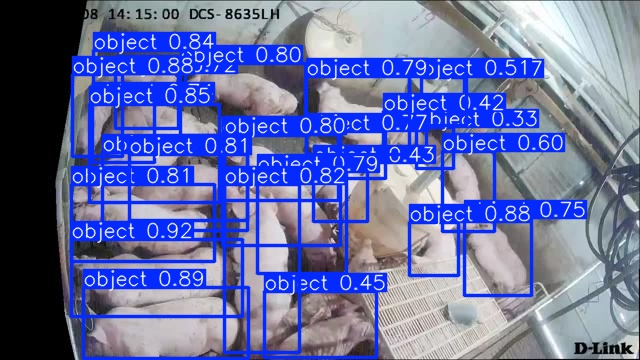

00000002.jpg


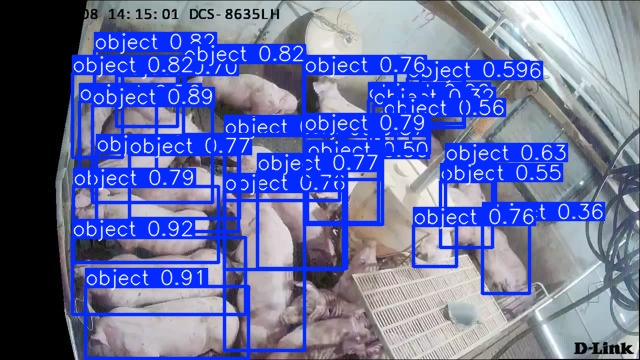

00000003.jpg


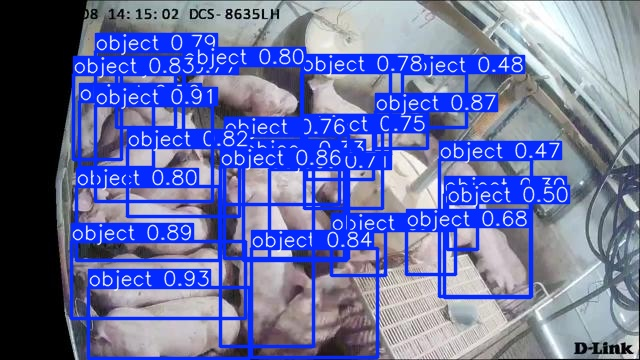

00000004.jpg


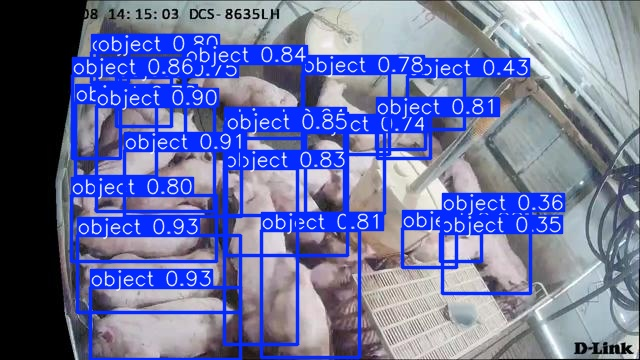

00000005.jpg


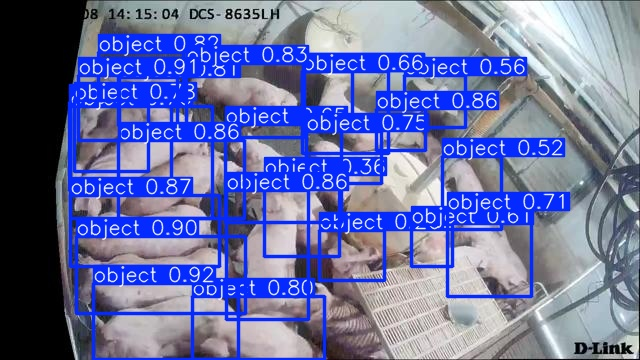

In [30]:
from pathlib import Path
from PIL import Image
from IPython.display import display

vis_dir = Path(r"C:\Users\11958\Desktop\vscode-c\c\cv\hw1\runs\detect\pred_test\result_picture")
assert vis_dir.exists(), f"目录不存在：{vis_dir}"

exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
files = sorted([p for p in vis_dir.iterdir() if p.suffix.lower() in exts], key=lambda p: p.stem)[:5]
assert files, f"{vis_dir} 下没有找到图片"

print("使用目录：", vis_dir)
for p in files:
    print(p.name)
    display(Image.open(p))
